In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import cartopy.crs as ccrs
import numpy as np
import scipy.stats as sts
from sqlalchemy import create_engine

In [2]:
# Create engine 
engine = create_engine("sqlite:///data/hashtag2020.db", echo=True)
conn = engine.connect()

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: http://sqlalche.me/e/e3q8)

In [ ]:
#Create the table. If we use automap_base, the table must have a primary key
conn.execute("""
    CREATE TABLE IF NOT EXISTS political_bias (
        id integer PRIMARY KEY,
        political bias VARCHAR(15),
        hashtags in tweets VARCHAR(280),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5)
        
    )
""")

In [3]:
trump_csv_path = "hashtag_donaldtrump.csv"
biden_csv_path = "hashtag_joebiden.csv"

In [4]:
trump_df = pd.read_csv(trump_csv_path, delimiter = ',', lineterminator='\n')
biden_df = pd.read_csv(biden_csv_path, delimiter = ',', lineterminator='\n')

In [5]:
trump_df.head()
biden_df.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [6]:
trump_data_df = trump_df[['created_at', 'tweet', 'likes', 'retweet_count', 'source','user_location', 'lat', 'long', 'city','state','state_code','country']]
trump_data_df.head()
biden_data_df = biden_df[['created_at', 'tweet', 'likes', 'retweet_count', 'source','user_location', 'lat', 'long', 'city','state','state_code','country']]
biden_data_df.head()

,created_at,tweet,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,Florida,FL,United States of America
1,2020-10-15 00:00:18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,Golden Valley Arizona,46.304036,-109.171431,NaN,Montana,MT,United States of America
3,2020-10-15 00:00:21,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,"California, USA",36.701463,-118.755997,NaN,California,CA,United States of America


In [7]:
str_cols = ['user_location', 'city', 'state', 'state_code', 'country']
trump_data_df.loc[:, 'lat'] = trump_data_df.loc[:, 'lat'].fillna(91)
trump_data_df.loc[:, 'long'] = trump_data_df.loc[:, 'long'].fillna(181)
trump_data_df.loc[:, str_cols] = trump_data_df.loc[:, str_cols].fillna("Not Provided")
trump_data_df.head()
str_cols = ['user_location', 'city', 'state', 'state_code', 'country']
biden_data_df.loc[:, 'lat'] = biden_data_df.loc[:, 'lat'].fillna(91)
biden_data_df.loc[:, 'long'] = biden_data_df.loc[:, 'long'].fillna(181)
biden_data_df.loc[:, str_cols] = biden_data_df.loc[:, str_cols].fillna("Not Provided")
biden_data_df.head()

C:\Users\15037\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,created_at,tweet,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,Not Provided,Florida,FL,United States of America
1,2020-10-15 00:00:18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,Not Provided,91.000000,181.000000,Not Provided,Not Provided,Not Provided,Not Provided
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,Golden Valley Arizona,46.304036,-109.171431,Not Provided,Montana,MT,United States of America
3,2020-10-15 00:00:21,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,Not Provided,91.000000,181.000000,Not Provided,Not Provided,Not Provided,Not Provided
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,"California, USA",36.701463,-118.755997,Not Provided,California,CA,United States of America


In [8]:
trump_data_df = trump_data_df.loc[(trump_data_df['country'] == "United States of America") & (trump_data_df['long'] < 100),:]
trump_data_df
biden_data_df = biden_data_df.loc[(biden_data_df['country'] == "United States of America") & (biden_data_df['long'] < 100),:]

In [9]:
trump_likes = trump_data_df['likes']
trump_retweet_count = trump_data_df['retweet_count']
biden_likes = biden_data_df['likes']
biden_retweet_count = biden_data_df['retweet_count']

In [10]:
# distribution of trump tweet likes
mean_numpy = np.mean(trump_likes)
print(f"The mean number of hashtag trump tweet likes is {mean_numpy}")

median_numpy = np.median(trump_likes)
print(f"The median number of hashtag trump tweet likes is {median_numpy}")

mode_scipy = sts.mode(trump_likes)
print(f"The mode of hashtag trump tweet likes is {mode_scipy}")


# Distribution of biden tweet likes
mean_numpy = np.mean(biden_likes)
print(f"The mean number of hashtag biden tweet likes is {mean_numpy}")

median_numpy = np.median(biden_likes)
print(f"The median number of hashtag biden tweet likes is {median_numpy}")

mode_scipy = sts.mode(biden_likes)
print(f"The mode of hashtag biden tweet likes is {mode_scipy}")

The mean number of hashtag trump tweet likes is 8.504161659073759
The median number of hashtag trump tweet likes is 0.0
The mode of hashtag trump tweet likes is ModeResult(mode=array([0.]), count=array([108024]))
The mean number of hashtag biden tweet likes is 13.702083468975845
The median number of hashtag biden tweet likes is 0.0
The mode of hashtag biden tweet likes is ModeResult(mode=array([0.]), count=array([83194]))


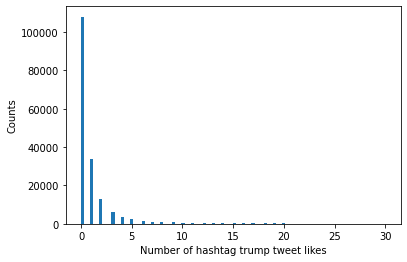

In [11]:
# Histogramp of trump likes
plt.hist(trump_likes, bins=100, range = [0,30])
plt.xlabel('Number of hashtag trump tweet likes')
plt.ylabel('Counts')
plt.show()

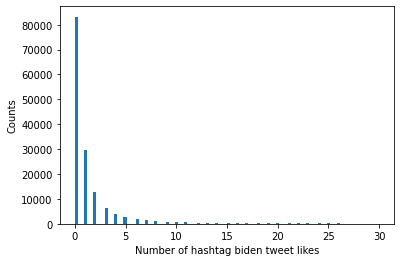

In [12]:
# Characterize the data set using matplotlib
plt.hist(biden_likes, bins=100, range = [0,30])
plt.xlabel('Number of hashtag biden tweet likes')
plt.ylabel('Counts')
plt.show()

In [13]:
# distribution of trump retweets
mean_numpy = np.mean(trump_retweet_count)
print(f"The mean number of hashtag trump retweets is {mean_numpy}")

median_numpy = np.median(trump_retweet_count)
print(f"The median number of hashtag trump retweets is {median_numpy}")

mode_scipy = sts.mode(trump_retweet_count)
print(f"The mode of hashtag trump retweets is {mode_scipy}")


# Distribution of biden retweets
mean_numpy = np.mean(biden_retweet_count)
print(f"The mean number of hashtag biden retweets is {mean_numpy}")

median_numpy = np.median(biden_retweet_count)
print(f"The median number of hashtag biden retweets is {median_numpy}")

mode_scipy = sts.mode(biden_retweet_count)
print(f"The mode of hashtag biden retweets is {mode_scipy}")

The mean number of hashtag trump retweets is 2.1698426451270296
The median number of hashtag trump retweets is 0.0
The mode of hashtag trump retweets is ModeResult(mode=array([0.]), count=array([146443]))
The mean number of hashtag biden retweets is 3.1088352106256916
The median number of hashtag biden retweets is 0.0
The mode of hashtag biden retweets is ModeResult(mode=array([0.]), count=array([121410]))


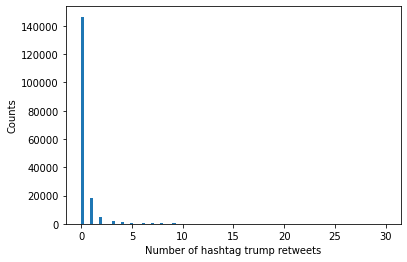

In [14]:
# Characterize the data set using matplotlib
plt.hist(trump_retweet_count, bins=100, range = [0,30])
plt.xlabel('Number of hashtag trump retweets')
plt.ylabel('Counts')
plt.show()

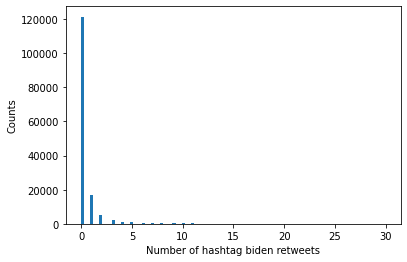

In [15]:
# Characterize the data set using matplotlib
plt.hist(biden_retweet_count, bins=100, range = [0,30])
plt.xlabel('Number of hashtag biden retweets')
plt.ylabel('Counts')
plt.show()

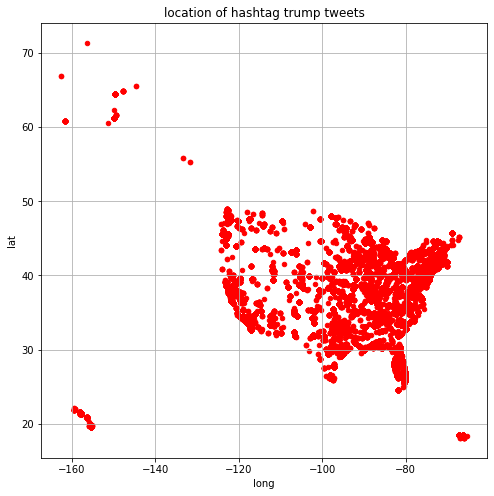

In [16]:
test = trump_data_df.plot(kind="scatter", x="long", y="lat", grid=True, figsize=(8,8),
              title="location of hashtag trump tweets",color = 'r')

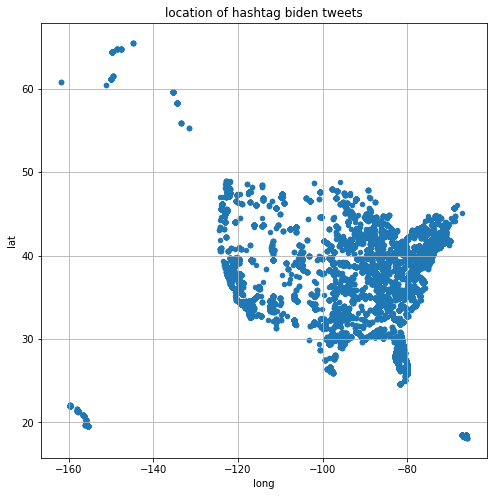

In [17]:
test = biden_data_df.plot(kind="scatter", x="long", y="lat", grid=True, figsize=(8,8),
              title="location of hashtag biden tweets")

In [18]:
# using naive method to get count  
# counting #'s in trump tweets
trump_tweets = trump_data_df['tweet']
hashtag_count = []

for tweet in trump_tweets:
    
    count = 0
  
    for i in tweet: 
        if i == '#': 
            count = count + 1
    hashtag_count.append(count)
        
hashtag_count

[8,
 1,
 2,
 2,
 1,
 2,
 6,
 15,
 3,
 1,
 5,
 11,
 4,
 7,
 2,
 6,
 8,
 2,
 2,
 4,
 1,
 5,
 9,
 11,
 1,
 6,
 2,
 8,
 3,
 1,
 1,
 1,
 1,
 11,
 4,
 5,
 3,
 2,
 3,
 2,
 1,
 9,
 5,
 7,
 10,
 17,
 3,
 1,
 3,
 3,
 1,
 3,
 17,
 4,
 1,
 1,
 1,
 9,
 2,
 2,
 5,
 2,
 2,
 1,
 1,
 16,
 4,
 1,
 4,
 1,
 6,
 12,
 2,
 5,
 9,
 3,
 1,
 1,
 2,
 3,
 3,
 1,
 11,
 1,
 3,
 2,
 5,
 1,
 17,
 5,
 3,
 1,
 5,
 3,
 4,
 1,
 5,
 1,
 1,
 4,
 1,
 1,
 1,
 5,
 1,
 5,
 2,
 7,
 1,
 3,
 1,
 2,
 2,
 5,
 1,
 1,
 9,
 9,
 2,
 1,
 2,
 1,
 1,
 6,
 4,
 2,
 2,
 4,
 1,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 2,
 8,
 3,
 4,
 8,
 10,
 1,
 3,
 13,
 11,
 7,
 1,
 2,
 1,
 5,
 6,
 1,
 4,
 1,
 2,
 6,
 1,
 1,
 1,
 2,
 4,
 3,
 3,
 1,
 4,
 3,
 1,
 2,
 1,
 4,
 1,
 3,
 2,
 4,
 8,
 4,
 1,
 1,
 1,
 9,
 1,
 12,
 5,
 2,
 3,
 2,
 3,
 3,
 22,
 4,
 2,
 2,
 1,
 8,
 1,
 3,
 12,
 7,
 1,
 7,
 3,
 2,
 3,
 5,
 1,
 5,
 3,
 2,
 1,
 1,
 17,
 1,
 2,
 1,
 8,
 5,
 7,
 4,
 1,
 2,
 2,
 1,
 1,
 8,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 3,
 5,
 4,
 11,
 2,
 3,
 12,
 4,
 1,
 1,


In [19]:
# using naive method to get count  
# counting #'s in biden tweets
biden_tweets = biden_data_df['tweet']
hashtag_count = []

for tweet in biden_tweets:
    
    count = 0
  
    for i in tweet: 
        if i == '#': 
            count = count + 1
    hashtag_count.append(count)
        
hashtag_count

[8,
 2,
 6,
 6,
 2,
 11,
 4,
 4,
 4,
 1,
 4,
 1,
 11,
 5,
 5,
 1,
 1,
 1,
 5,
 3,
 1,
 1,
 5,
 1,
 5,
 7,
 1,
 1,
 4,
 4,
 8,
 4,
 4,
 3,
 5,
 7,
 3,
 1,
 4,
 2,
 1,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 1,
 4,
 5,
 3,
 1,
 4,
 4,
 1,
 1,
 9,
 3,
 2,
 4,
 1,
 1,
 4,
 2,
 3,
 2,
 1,
 4,
 1,
 2,
 7,
 14,
 18,
 1,
 2,
 2,
 4,
 6,
 12,
 9,
 1,
 1,
 2,
 2,
 6,
 1,
 2,
 3,
 3,
 1,
 7,
 6,
 3,
 5,
 3,
 2,
 2,
 8,
 4,
 1,
 3,
 13,
 5,
 4,
 3,
 1,
 1,
 5,
 2,
 8,
 4,
 5,
 1,
 6,
 6,
 2,
 6,
 4,
 3,
 6,
 4,
 9,
 7,
 8,
 4,
 3,
 3,
 2,
 5,
 1,
 1,
 3,
 8,
 1,
 1,
 1,
 5,
 1,
 2,
 2,
 5,
 2,
 2,
 2,
 22,
 2,
 1,
 7,
 4,
 1,
 2,
 3,
 3,
 11,
 4,
 3,
 3,
 4,
 4,
 4,
 10,
 6,
 1,
 2,
 5,
 4,
 5,
 5,
 2,
 3,
 5,
 5,
 8,
 1,
 1,
 5,
 2,
 4,
 4,
 1,
 2,
 2,
 4,
 1,
 2,
 8,
 1,
 6,
 7,
 4,
 3,
 4,
 6,
 3,
 1,
 4,
 19,
 4,
 6,
 5,
 3,
 1,
 12,
 1,
 4,
 3,
 12,
 5,
 6,
 4,
 2,
 6,
 10,
 6,
 1,
 3,
 6,
 3,
 2,
 1,
 3,
 3,
 5,
 1,
 2,
 1,
 5,
 4,
 1,
 3,
 4,
 6,
 3,
 1,
 10,
 2,
 3,
 1,
 3,
 1,
 2,
 1,
 3,
 5,
 8

In [20]:
# Distribution of hashtag trump
mean_numpy = np.mean(hashtag_count)
print(f"The mean number of hashtags in a tweet is {mean_numpy}")

median_numpy = np.median(hashtag_count)
print(f"The median number of hashtags in a tweet is {median_numpy}")

mode_scipy = sts.mode(hashtag_count)
print(f"The mode of hashtags in a tweet is {mode_scipy}")


# Distribution of hashtag biden
mean_numpy = np.mean(hashtag_count)
print(f"The mean number of hashtags in a tweet is {mean_numpy}")

median_numpy = np.median(hashtag_count)
print(f"The median number of hashtags in a tweet is {median_numpy}")

mode_scipy = sts.mode(hashtag_count)
print(f"The mode of hashtags in a tweet is {mode_scipy}")

The mean number of hashtags in a tweet is 4.175245784230744
The median number of hashtags in a tweet is 3.0
The mode of hashtags in a tweet is ModeResult(mode=array([2]), count=array([30898]))
The mean number of hashtags in a tweet is 4.175245784230744
The median number of hashtags in a tweet is 3.0
The mode of hashtags in a tweet is ModeResult(mode=array([2]), count=array([30898]))


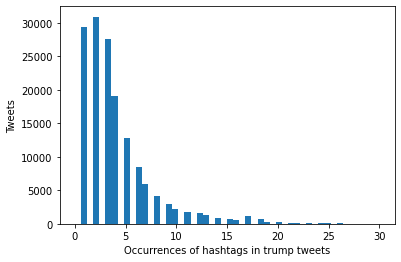

In [21]:
# Characterize the data set using matplotlib
plt.hist(hashtag_count, bins=50, range = [0,30])
plt.xlabel('Occurrences of hashtags in trump tweets')
plt.ylabel('Tweets')
plt.show()

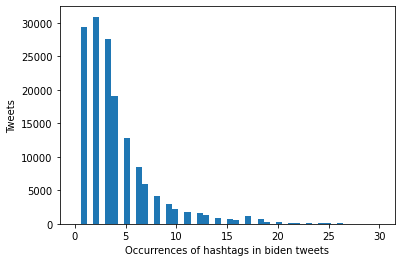

In [22]:
# Characterize the data set using matplotlib
plt.hist(hashtag_count, bins=50, range = [0,30])
plt.xlabel('Occurrences of hashtags in biden tweets')
plt.ylabel('Tweets')
plt.show()

In [23]:
dd = {"hashtag_count" : hashtag_count, "likes" : trump_likes}
trump_like_df = pd.DataFrame(dd)
trump_like_df

ValueError: array length 153590 does not match index length 178895

In [24]:
d = {"hashtag_count" : hashtag_count, "likes" : biden_likes}
df = pd.DataFrame(d)
df

,hashtag_count,likes
0,8,0.0
2,2,0.0
4,6,1.0
6,6,0.0
11,2,0.0
...,...,...
776861,4,0.0
776862,2,0.0
776865,1,0.0
776870,2,0.0


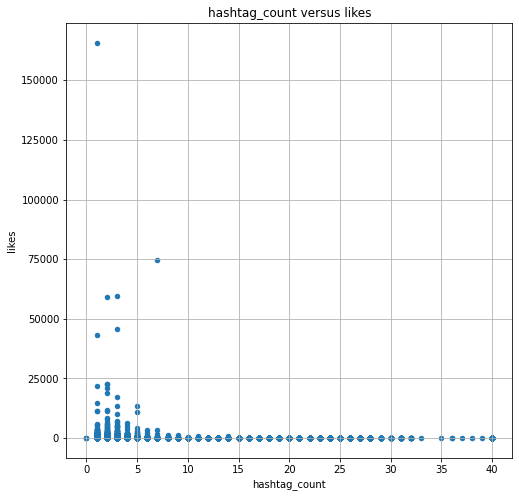

In [25]:
test = df.plot(kind="scatter", x="hashtag_count", y="likes", grid=True, figsize=(8,8),
              title="hashtag_count versus likes")

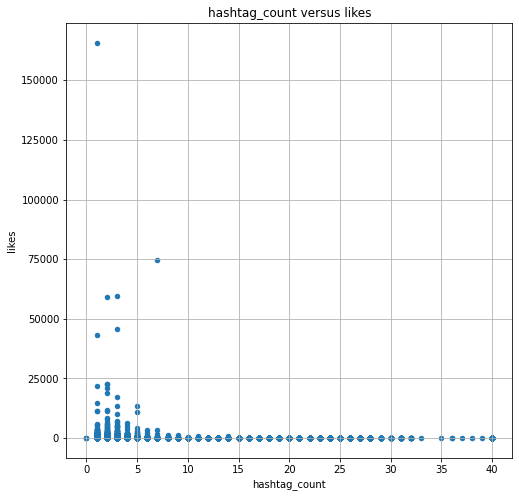

In [26]:
test = df.plot(kind="scatter", x="hashtag_count", y="likes", grid=True, figsize=(8,8),
              title="hashtag_count versus likes")

In [27]:
d = {"hashtag_count" : hashtag_count, "retweet_count" : trump_retweet_count}
df = pd.DataFrame(d)
df

ValueError: array length 153590 does not match index length 178895

In [28]:
d = {"hashtag_count" : hashtag_count, "retweet_count" : biden_retweet_count}
df = pd.DataFrame(d)
df

,hashtag_count,retweet_count
0,8,0.0
2,2,0.0
4,6,0.0
6,6,0.0
11,2,0.0
...,...,...
776861,4,0.0
776862,2,0.0
776865,1,0.0
776870,2,0.0


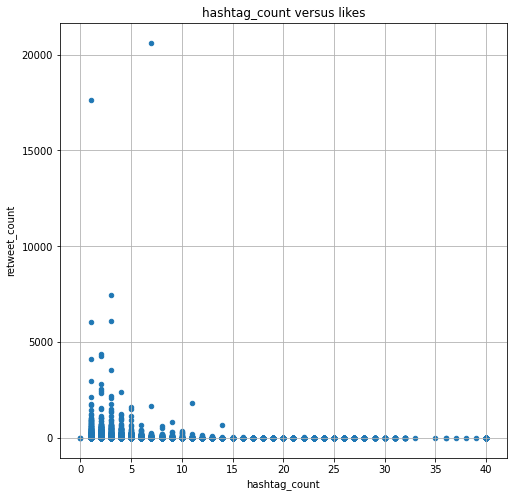

In [29]:
test = df.plot(kind="scatter", x="hashtag_count", y="retweet_count", grid=True, figsize=(8,8),
              title="hashtag_count versus likes")

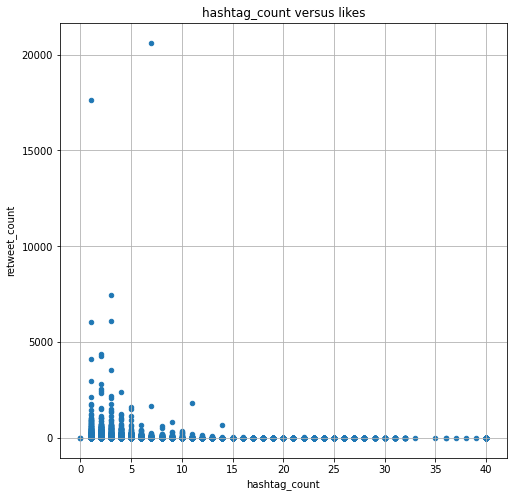

In [30]:
test = df.plot(kind="scatter", x="hashtag_count", y="retweet_count", grid=True, figsize=(8,8),
              title="hashtag_count versus likes")

In [31]:
words_in_trump_tweets = []
unique_trump_words = []
unique_trump_word_counts = []

for tweet in trump_tweets:
    
    tweet += ' '
    words = []
    j = ''
    word = ''
    
    for i in tweet: 
        if (j in ['#']) & (i not in [' ','\n','.','!',':',',','?','’']):
            word += i
        elif j in ['#']:
            words.append(word)
            if word not in unique_trump_words:
                unique_trump_words.append(word)
                unique_trump_word_counts.append(1)
            else:
                index = unique_trump_words.index(word)
                unique_trump_word_counts[index] = unique_trump_word_counts[index] + 1
            word = ''
            j = ''
        else:
            j = i
    words_in_trump_tweets.append(words)

In [32]:
words_in_biden_tweets = []
unique_biden_words = []
unique_biden_word_counts = []

for tweet in biden_tweets:
    
    tweet += ' '
    words = []
    j = ''
    word = ''
    
    for i in tweet: 
        if (j in ['#']) & (i not in [' ','\n','.','!',':',',','?','’']):
            word += i
        elif j in ['#']:
            words.append(word)
            if word not in unique_biden_words:
                unique_biden_words.append(word)
                unique_biden_word_counts.append(1)
            else:
                index = unique_biden_words.index(word)
                unique_biden_word_counts[index] = unique_biden_word_counts[index] + 1
            word = ''
            j = ''
        else:
            j = i
    words_in_biden_tweets.append(words)

In [33]:
trump_data_df
biden_data_df

,created_at,tweet,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,Not Provided,Florida,FL,United States of America
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,Golden Valley Arizona,46.304036,-109.171431,Not Provided,Montana,MT,United States of America
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,"California, USA",36.701463,-118.755997,Not Provided,California,CA,United States of America
6,2020-10-15 00:00:25,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,"Chicago, Illinois",41.875562,-87.624421,Chicago,Illinois,IL,United States of America
11,2020-10-15 00:00:57,"FBI Allegedly Obtained Hunter Biden Computer, ...",0.0,0.0,Twitter for Android,"Kentucky, USA",37.572603,-85.155141,Not Provided,Kentucky,KY,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
776861,2020-11-08 23:58:09,#election #2020Elections #trump #biden https:/...,0.0,0.0,Twitter for iPhone,"New York, USA",40.712728,-74.006015,New York,New York,NY,United States of America
776862,2020-11-08 23:58:10,@GOP @GOPLeader @senatemajldr @LindseyGrahamSC...,0.0,0.0,Twitter for Android,"Cape Cod, MA",41.798807,-69.996014,Not Provided,Massachusetts,MA,United States of America
776865,2020-11-08 23:58:24,@FLOTUS I’m excited to have a FLOTUS whose vag...,0.0,0.0,Twitter for iPhone,"Washington, DC",38.894992,-77.036558,Washington,District of Columbia,DC,United States of America
776870,2020-11-08 23:58:48,The man needs some help...#usa #biden\nWhen wi...,0.0,0.0,Twitter for Android,Earth. 3rd Planet from Sun.,43.519630,-114.315320,Not Provided,Idaho,ID,United States of America


In [34]:
trump_data_df.insert(2, "hashtags in tweets", "Any")
biden_data_df.insert(2, "hashtags in tweets", "Any")

In [35]:
trump_data_df['hashtags in tweets'] = words_in_trump_tweets
trump_data_df
biden_data_df['hashtags in tweets'] = words_in_biden_tweets
biden_data_df

,created_at,tweet,hashtags in tweets,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,"[Elecciones2020, Florida, JoeBiden, DonaldTrum...",0.0,0.0,TweetDeck,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,Not Provided,Florida,FL,United States of America
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,"[Biden, TrumpIsNotAmerica]",0.0,0.0,Twitter Web App,Golden Valley Arizona,46.304036,-109.171431,Not Provided,Montana,MT,United States of America
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,"[censorship, HunterBiden, Biden, BidenEmails, ...",1.0,0.0,Twitter Web App,"California, USA",36.701463,-118.755997,Not Provided,California,CA,United States of America
6,2020-10-15 00:00:25,"In 2020, #NYPost is being #censorship #CENSORE...","[NYPost, censorship, CENSORED, JoeBiden, Trump...",0.0,0.0,Twitter for iPhone,"Chicago, Illinois",41.875562,-87.624421,Chicago,Illinois,IL,United States of America
11,2020-10-15 00:00:57,"FBI Allegedly Obtained Hunter Biden Computer, ...","[JoeBiden, HunterBiden]",0.0,0.0,Twitter for Android,"Kentucky, USA",37.572603,-85.155141,Not Provided,Kentucky,KY,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776861,2020-11-08 23:58:09,#election #2020Elections #trump #biden https:/...,"[election, 2020Elections, trump, biden]",0.0,0.0,Twitter for iPhone,"New York, USA",40.712728,-74.006015,New York,New York,NY,United States of America
776862,2020-11-08 23:58:10,@GOP @GOPLeader @senatemajldr @LindseyGrahamSC...,"[Trump, Biden]",0.0,0.0,Twitter for Android,"Cape Cod, MA",41.798807,-69.996014,Not Provided,Massachusetts,MA,United States of America
776865,2020-11-08 23:58:24,@FLOTUS I’m excited to have a FLOTUS whose vag...,[biden],0.0,0.0,Twitter for iPhone,"Washington, DC",38.894992,-77.036558,Washington,District of Columbia,DC,United States of America
776870,2020-11-08 23:58:48,The man needs some help...#usa #biden\nWhen wi...,"[usa, biden]",0.0,0.0,Twitter for Android,Earth. 3rd Planet from Sun.,43.519630,-114.315320,Not Provided,Idaho,ID,United States of America


In [36]:
biden_data_df

,created_at,tweet,hashtags in tweets,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,"[Elecciones2020, Florida, JoeBiden, DonaldTrum...",0.0,0.0,TweetDeck,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,Not Provided,Florida,FL,United States of America
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,"[Biden, TrumpIsNotAmerica]",0.0,0.0,Twitter Web App,Golden Valley Arizona,46.304036,-109.171431,Not Provided,Montana,MT,United States of America
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,"[censorship, HunterBiden, Biden, BidenEmails, ...",1.0,0.0,Twitter Web App,"California, USA",36.701463,-118.755997,Not Provided,California,CA,United States of America
6,2020-10-15 00:00:25,"In 2020, #NYPost is being #censorship #CENSORE...","[NYPost, censorship, CENSORED, JoeBiden, Trump...",0.0,0.0,Twitter for iPhone,"Chicago, Illinois",41.875562,-87.624421,Chicago,Illinois,IL,United States of America
11,2020-10-15 00:00:57,"FBI Allegedly Obtained Hunter Biden Computer, ...","[JoeBiden, HunterBiden]",0.0,0.0,Twitter for Android,"Kentucky, USA",37.572603,-85.155141,Not Provided,Kentucky,KY,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776861,2020-11-08 23:58:09,#election #2020Elections #trump #biden https:/...,"[election, 2020Elections, trump, biden]",0.0,0.0,Twitter for iPhone,"New York, USA",40.712728,-74.006015,New York,New York,NY,United States of America
776862,2020-11-08 23:58:10,@GOP @GOPLeader @senatemajldr @LindseyGrahamSC...,"[Trump, Biden]",0.0,0.0,Twitter for Android,"Cape Cod, MA",41.798807,-69.996014,Not Provided,Massachusetts,MA,United States of America
776865,2020-11-08 23:58:24,@FLOTUS I’m excited to have a FLOTUS whose vag...,[biden],0.0,0.0,Twitter for iPhone,"Washington, DC",38.894992,-77.036558,Washington,District of Columbia,DC,United States of America
776870,2020-11-08 23:58:48,The man needs some help...#usa #biden\nWhen wi...,"[usa, biden]",0.0,0.0,Twitter for Android,Earth. 3rd Planet from Sun.,43.519630,-114.315320,Not Provided,Idaho,ID,United States of America


In [37]:
n = 44

tweet = trump_data_df.loc[trump_data_df.index[n],['tweet', 'hashtags in tweets']].values[0]
hashtags = trump_data_df.loc[trump_data_df.index[n],['tweet', 'hashtags in tweets']].values[1]

print(f"Tweet: {tweet} \n\n--------------------------------------------------------------------------------------\n\n Hashtag: {hashtags}")

Tweet: #FakePresident #DonaldTrump will continue his #COVID19 #SuperSpreaderEvent Tour, in #Iowa. Fake President Donald #Trump will be giving #TrumpSupporters COVID-19 #KoolAid in Iowa, on #Wednesday #October 14, 2020 https://t.co/5QQmHrJe7Z 

--------------------------------------------------------------------------------------

 Hashtag: ['FakePresident', 'DonaldTrump', 'COVID19', 'SuperSpreaderEvent', 'Iowa', 'Trump', 'TrumpSupporters', 'KoolAid', 'Wednesday', 'October']


In [38]:
n = 44

tweet = biden_data_df.loc[biden_data_df.index[n],['tweet', 'hashtags in tweets']].values[0]
hashtags = biden_data_df.loc[biden_data_df.index[n],['tweet', 'hashtags in tweets']].values[1]

print(f"Tweet: {tweet} \n\n--------------------------------------------------------------------------------------\n\n Hashtag: {hashtags}")

Tweet: @ChrisMegerian how much is the #JoeBiden campaign paying you to ‘try’ to diffuse the #HunterBiden bombshell? 

--------------------------------------------------------------------------------------

 Hashtag: ['JoeBiden', 'HunterBiden']


In [39]:
trump_data_df
biden_data_df

,created_at,tweet,hashtags in tweets,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,"[Elecciones2020, Florida, JoeBiden, DonaldTrum...",0.0,0.0,TweetDeck,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,Not Provided,Florida,FL,United States of America
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,"[Biden, TrumpIsNotAmerica]",0.0,0.0,Twitter Web App,Golden Valley Arizona,46.304036,-109.171431,Not Provided,Montana,MT,United States of America
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #...,"[censorship, HunterBiden, Biden, BidenEmails, ...",1.0,0.0,Twitter Web App,"California, USA",36.701463,-118.755997,Not Provided,California,CA,United States of America
6,2020-10-15 00:00:25,"In 2020, #NYPost is being #censorship #CENSORE...","[NYPost, censorship, CENSORED, JoeBiden, Trump...",0.0,0.0,Twitter for iPhone,"Chicago, Illinois",41.875562,-87.624421,Chicago,Illinois,IL,United States of America
11,2020-10-15 00:00:57,"FBI Allegedly Obtained Hunter Biden Computer, ...","[JoeBiden, HunterBiden]",0.0,0.0,Twitter for Android,"Kentucky, USA",37.572603,-85.155141,Not Provided,Kentucky,KY,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776861,2020-11-08 23:58:09,#election #2020Elections #trump #biden https:/...,"[election, 2020Elections, trump, biden]",0.0,0.0,Twitter for iPhone,"New York, USA",40.712728,-74.006015,New York,New York,NY,United States of America
776862,2020-11-08 23:58:10,@GOP @GOPLeader @senatemajldr @LindseyGrahamSC...,"[Trump, Biden]",0.0,0.0,Twitter for Android,"Cape Cod, MA",41.798807,-69.996014,Not Provided,Massachusetts,MA,United States of America
776865,2020-11-08 23:58:24,@FLOTUS I’m excited to have a FLOTUS whose vag...,[biden],0.0,0.0,Twitter for iPhone,"Washington, DC",38.894992,-77.036558,Washington,District of Columbia,DC,United States of America
776870,2020-11-08 23:58:48,The man needs some help...#usa #biden\nWhen wi...,"[usa, biden]",0.0,0.0,Twitter for Android,Earth. 3rd Planet from Sun.,43.519630,-114.315320,Not Provided,Idaho,ID,United States of America


In [145]:
bags_of_hashtags = []
for n in range(len(biden_data_df)):
    bag = biden_data_df.loc[biden_data_df.index[n], "hashtags in tweets"]
    bags_of_hashtags.append(bag)

In [146]:
bags_of_hashtags

[['Elecciones2020',
  'Florida',
  'JoeBiden',
  'DonaldTrump',
  'PembrokePines',
  'Miramar',
  'ElSolLatino',
  'yobrilloconelsol'],
 ['Biden', 'TrumpIsNotAmerica'],
 ['censorship',
  'HunterBiden',
  'Biden',
  'BidenEmails',
  'BidenEmail',
  'Corruption'],
 ['NYPost', 'censorship', 'CENSORED', 'JoeBiden', 'Trump', 'China'],
 ['JoeBiden', 'HunterBiden'],
 ['China',
  'HunterBiden',
  'JoeBiden',
  'BidenHarris',
  'BidenHarris2020',
  'TrumpPence2020',
  'Trump',
  'realDonaldTrump',
  'WTO',
  'coronavirus',
  'trade'],
 ['NYPost', 'HunterBiden', 'Biden', 'Election2020'],
 ['TwitterCensorship', 'Biden', 'Ukraine', 'HunterBiden'],
 ['BidenCrimeFamily', 'JoeBiden', 'HunterBiden', 'HunterBidenEmails'],
 ['JoeBiden'],
 ['Trump', 'Biden', 'TrumpRally', 'HunterBidenEmails'],
 ['biden'],
 ['realDonaldTrump',
  'JoeBiden',
  'HunterBiden',
  'ObamaBidenGate',
  'NYPost',
  'MSNBC',
  'CBS',
  'NBC',
  'ABC',
  'FoxNews',
  'KamalaHarris'],
 ['2020Election', 'DonaldTrump', 'JoeBiden', 'us

In [147]:
heads = []
Heads = []
hashtag_collection = []
# _o_ = range(len(neutral))
# o = random.choice(_o_)
# heads.append(unique_trump_words[o])
heads.append('LGBTQForBiden')
Heads.append(heads)
hashtag_collection.append('LGBTQForBiden')
# bags_of_hashtags = trump_data_df.loc[:, "hashtags in tweets"].values
for heads in Heads:
    H = []
    hashtags = []
    for head in heads:
        i = -1
        for bag in bags_of_hashtags:
            i = i + 1
            if head in bag:
                for hashtag in bag:
                    if (hashtag not in hashtag_collection) & (hashtag != 'Biden') & (hashtag != 'Trump') & (hashtag != 'JoeBiden'):
                        hashtag_collection.append(hashtag)
                        hashtags.append(hashtag)
                bags_of_hashtags.pop(i)
    if hashtags != []:
        Heads.append(hashtags)        

In [ ]:
heads = []
Heads = []
hashtag_collection = []
# _o_ = range(len(neutral))
# o = random.choice(_o_)
# heads.append(unique_trump_words[o])
heads.append('LGBTQForBiden')
Heads.append(heads)
hashtag_collection.append('LGBTQForBiden')
# bags_of_hashtags = trump_data_df.loc[:, "hashtags in tweets"].values
for heads in Heads:
    H = []
    hashtags = []
    for head in heads:
        i = -1
        for bag in bags_of_hashtags:
            i = i + 1
            if head in bag:
                for hashtag in bag:
                    if (hashtag not in hashtag_collection) & (hashtag != 'Biden') & (hashtag != 'Trump') & (hashtag != 'JoeBiden'):
                        hashtag_collection.append(hashtag)
                        hashtags.append(hashtag)
                bags_of_hashtags.pop(i)
    if hashtags != []:
        Heads.append(hashtags)   

In [139]:
for Head in Heads:
    print(len(Head))

1
16
1867
40853
4474
88
2


In [143]:
Heads[5]

['YouCantMakeThisUp',
 'TearsOfJoy😭',
 'GodBlessAmerica🇺🇲',
 'BidenHarris🙏',
 'KamalaHarris💙',
 'BidenHarrisToSaveAmerica🇺🇲',
 'HackedEmails',
 'WeCanTrustBiden',
 'JoeDEMentia',
 'BlackPresidentObama',
 'JoeSays',
 'figurehead',
 "NV's",
 'Trump300',
 '294to244',
 'JoeBiden🌊🇺🇸🌊🇺🇸🌊🇺🇸',
 'Bidenflipflop',
 'Financial_Oligarchs',
 'thePresident',
 'TruthInJest',
 'YouAreAJoke',
 'ItsJustnotFunnyAnymore',
 '50',
 'MSTV',
 'RockySteps',
 'PeeHaw',
 'Yale',
 'COAL',
 'CarterAdministration',
 'LopezObrador',
 'SeniorsAgainstBiden',
 'GunPlan',
 'Aggressive',
 'ComingForYourMoney',
 'NewGreenDeal',
 'BidenWillRaiseYourTaxes',
 '545Children',
 'GoneBY',
 'JoeCallsALid',
 'givingup',
 'AtheistVoter',
 'PredatorsOnOurStreet',
 'Wp',
 'Thingsthatmakeyougohmm',
 'ElectricVehicle',
 'cuckoo',
 'plagerized',
 'court_packing',
 'Democratic_Congress',
 'CongressSupreme',
 "Wisconsin'i",
 'HeCanCancelDebates',
 "Heart's",
 'Content',
 'TheBetter',
 'CancelDebates',
 'BidenHarrisLandSlide2020',
 'GOJOE&a

In [142]:
import random

#neutral is the collection of all unique hashtags

neutral = unique_trump_words

heads = []
Heads = []
_o_ = range(len(neutral))

while Heads == []:
    tails = heads
    o = random.choice(_o_)
    heads.append(unique_trump_words[o])
    bags_of_hashtags = trump_data_df.loc[:, "hashtags in tweets"].values
    for head in heads:
        for bag in bags_of_hashtags:
            if head in bag:
                Heads.append(bag)
    for tail in tails:
        for Head in Heads:
            if tail in Head:
                Tails = Heads
                Heads = []
            
while Heads != []:
    heads.append(word from Heads)
    for head in heads:
        for bag in bags_of_hashtags:
            if head in bag:
                Heads.append(bag)
    for tail in tails:
        for Head in Heads:
            if tail in Head:
                Tails = Heads
                Heads = []


In [144]:
Heads

[['ElectionDay',
  'Iran',
  'Trump',
  'FBI',
  'ProudBoys',
  'ChickenNuggets',
  'IceFishing',
  'OpioidCrisis',
  'FlockOfSeagulls',
  'Alaska',
  'Halloween2020',
  'Election2020']]

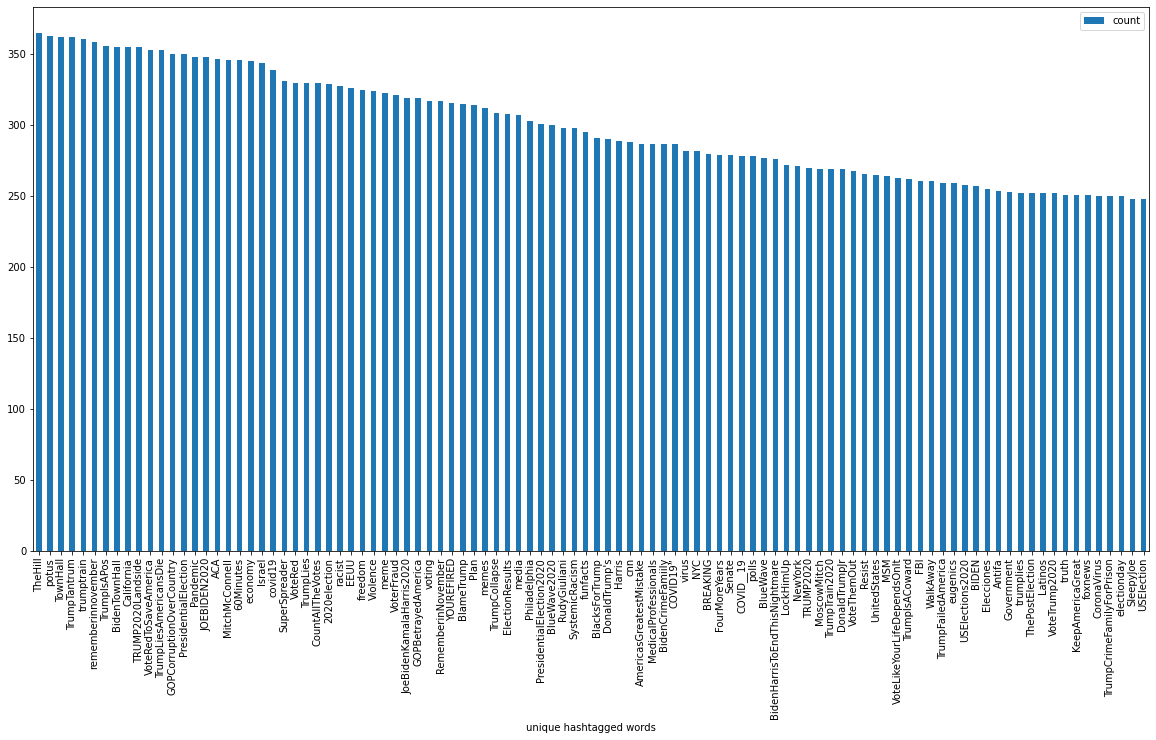

In [48]:
len(words_in_trump_tweets)
d = {"unique hashtagged words" : unique_trump_words, "count" : unique_trump_word_counts}
df = pd.DataFrame(d)
trump_word_count = df.sort_values('count', ascending=False)[200:300]

ax = trump_word_count.plot.bar(x='unique hashtagged words', y='count', rot=90, figsize=(20,10))
plt.show()

In [50]:
pro_trump_hashtags = ['Trump2020Landslide','TRUMP2020ToSaveAmerica','4MoreYears', 'Trump2020LandslideVictory', 'MAGA2020LandslideVictory', 'TrumpTrain', 'FakeNews', 'RedWave', 'CountEveryLegalVote', 'LatinosForTrump', 'VoteRedToSaveAmerica', 'VoteRed', 'CountAllTheVotes','BlacksForTrump','FourMoreYears','TrumpTrain2020','']
against_trump_hashtags = ['TrumpMeltdown','VoteHimOut','TrumpIsLosing','TrumpCrimeFamily','TrumpIsANationalDisgrace','dumptrump','VoteHimOut2020','VoteThemAllOut','antitrump','FtrumpS','murderinchief','shitler','FuckTrumpsShit','TrumpIsPathetic','TrumpVirus','DumpTrump','TrumpIsCompromised','ByeByeTrump','TrumpIsNotAmerica','TrumpIsALoser','VoteBlueToEndTheNightmare','VoteBLueToEndThisNightmare','DonTheCon','DumpTrump2020','TrumpIsNotWell','AmericaOrTrump','LiarInChief','TrumpIsARacist']
city_groups = trump_data_df.groupby(["city", "state_code"])["city"].count()
city_groups.head(100)
len(unique_trump_words)

63020

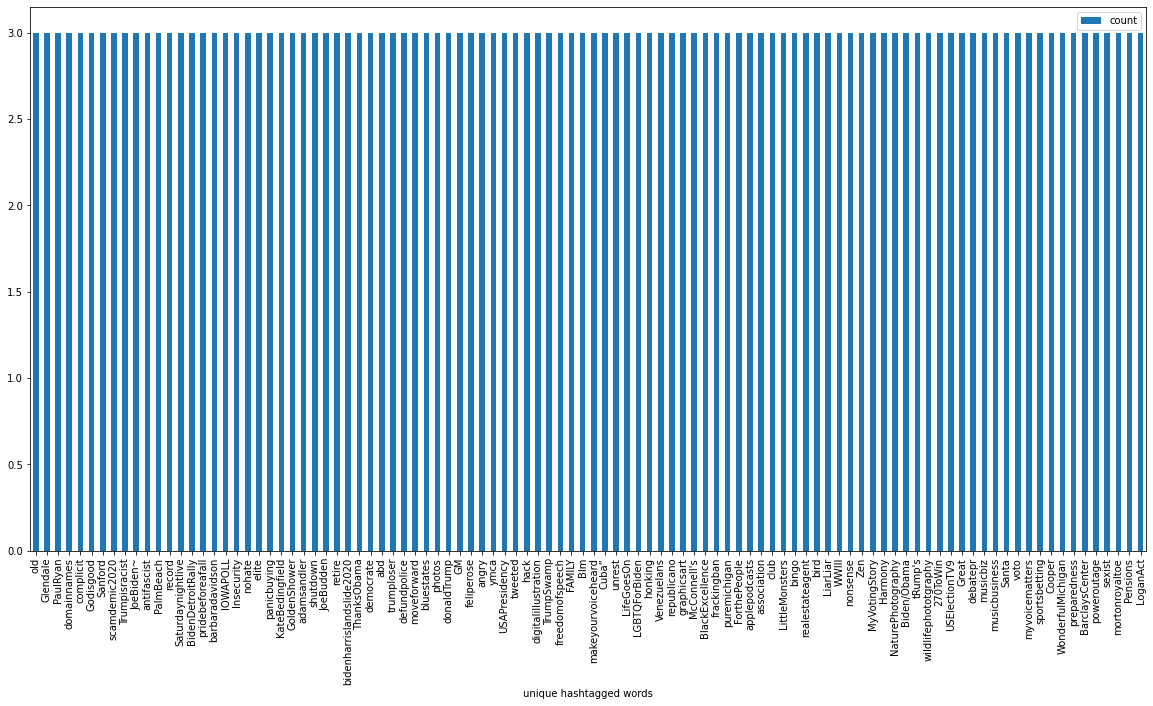

In [144]:
len(words_in_biden_tweets)
d = {"unique hashtagged words" : unique_biden_words, "count" : unique_biden_word_counts}
df = pd.DataFrame(d)
biden_word_count = df.sort_values('count', ascending=False)[9900:10000]

ax = biden_word_count.plot.bar(x='unique hashtagged words', y='count', rot=90, figsize=(20,10))
plt.show()

In [53]:
pro_biden_hashtags = ['wtpBlue','BidenHarriesToSaveAmerica','BlueWave','voteblue','BidenHarris2020ToSaveAmerica','wtpBiden','VoteBlue','BidenHarris2020Landslide','VoteBidenHarrisToSaveAmerica','VoteBlueToSaveAmerica','VoteBlueDownBallot','BidenCares']
against_biden_hashtags = ['BidenCrimeFamily','HunterBidenEmails','Hunterbidenlaptop','CrookedJoeBiden','BidenCrimeFamily','BidenCorruption','BidenCrimeFamily','SleepyJoe','CorruptJoeBiden','WheresHunter','LaptopFromHell']
city_groups = biden_data_df.groupby(["city", "state_code"])["city"].count()
city_groups.head(100)
len(unique_biden_words)

50738

In [55]:
for_trump = []

i = -1

for hashtags in trump_data_df['hashtags in tweets']:
    i = i + 1
    for hashtag_r in pro_trump_hashtags:
        count = 0
        for hashtag_b in against_trump_hashtags:
            if hashtag_b in hashtags:
                count =  count + 1
        if (hashtag_r in hashtags) & (count == 0):
            row = trump_data_df.loc[trump_data_df.index[i], :].values
            for_trump.append(row)
            count = count + 1
                        

In [56]:
against_trump = []

i = -1

for hashtags in trump_data_df['hashtags in tweets']:
    i = i + 1
    for hashtag_b in against_trump_hashtags:
        count = 0
        for hashtag_r in pro_trump_hashtags:
            if hashtag_r in hashtags:
                count =  count + 1
        if (hashtag_b in hashtags) & (count == 0):
            row = trump_data_df.loc[trump_data_df.index[i], :].values
            against_trump.append(row)
            count = count + 1

In [57]:
for_biden = []

i = -1

for hashtags in biden_data_df['hashtags in tweets']:
    i = i + 1
    for hashtag_r in pro_biden_hashtags:
        count = 0
        for hashtag_b in against_biden_hashtags:
            if hashtag_b in hashtags:
                count =  count + 1
        if (hashtag_r in hashtags) & (count == 0):
            row = biden_data_df.loc[biden_data_df.index[i], :].values
            for_biden.append(row)
            count = count + 1    

In [58]:
against_biden = []

i = -1

for hashtags in biden_data_df['hashtags in tweets']:
    i = i + 1
    for hashtag_b in against_biden_hashtags:
        count = 0
        for hashtag_r in pro_biden_hashtags:
            if hashtag_r in hashtags:
                count =  count + 1
        if (hashtag_b in hashtags) & (count == 0):
            row = biden_data_df.loc[biden_data_df.index[i], :].values
            against_biden.append(row)
            count = count + 1

In [78]:
cols = ['created_at', 'tweet', 'hashtags in tweets', 'likes', 'retweet_count', 'source','user_location', 'lat', 'long', 'city','state','state_code','country']
for_trump_df = pd.DataFrame(for_trump, columns=cols)
for_trump_df.insert(2, "political bias", "For Trump")
# for_trump_df.drop("political bias", inplace=True, axis=1)

In [79]:
for_trump_df

,created_at,tweet,political bias,hashtags in tweets,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:00:26,#Trump #PresidentTrump #Trump2020LandslideVict...,For Trump,"[Trump, PresidentTrump, Trump2020LandslideVict...",3.0,5.0,Twitter for Android,"San Diego, CA",32.717421,-117.162771,San Diego,California,CA,United States of America
1,2020-10-15 00:00:26,#Trump #PresidentTrump #Trump2020LandslideVict...,For Trump,"[Trump, PresidentTrump, Trump2020LandslideVict...",3.0,5.0,Twitter for Android,"San Diego, CA",32.717421,-117.162771,San Diego,California,CA,United States of America
2,2020-10-15 00:01:42,#BlacksForTrump \n#BlackVoicesForTrump \n#Bide...,For Trump,"[BlacksForTrump, BlackVoicesForTrump, BidenIsA...",1.0,1.0,Twitter Web App,"California, USA",36.701463,-118.755997,Not Provided,California,CA,United States of America
3,2020-10-15 00:02:48,We don't need no education\n\nWE DON'T NEED NO...,For Trump,"[realDonaldTrump, DonaldTrumpJr, Debates2020, ...",0.0,1.0,Twitter for Android,"Florida, USA",27.756767,-81.463983,Not Provided,Florida,FL,United States of America
4,2020-10-15 00:03:10,Did Twitter block me for screenshotting the Hu...,For Trump,"[Trump, TrumpTrain, TrumpPence2020]",0.0,0.0,Twitter for Android,"Houston, Texas",29.758938,-95.367697,Houston,Texas,TX,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9114,2020-11-08 23:04:33,@realDonaldTrump @marklevinshow ⚠️ 🛑 DON'T LET...,For Trump,"[DEMOCRATS, AMERICA, StopTheSteal, Trump2020, ...",1.0,0.0,Twitter Web App,"Columbus, OH",39.962260,-83.000706,Columbus,Ohio,OH,United States of America
9115,2020-11-08 23:05:18,@kayleighmcenany @realDonaldTrump ⚠️ 🛑 DON'T L...,For Trump,"[DEMOCRATS, AMERICA, StopTheSteal, Trump2020, ...",1.0,0.0,Twitter Web App,"Columbus, OH",39.962260,-83.000706,Columbus,Ohio,OH,United States of America
9116,2020-11-08 23:07:59,@BillOReilly ⚠️ 🛑 STOP THE CORRUPT #DEMOCRATS ...,For Trump,"[DEMOCRATS, AMERICA, StopTheSteal, Trump2020, ...",3.0,1.0,Twitter Web App,"Columbus, OH",39.962260,-83.000706,Columbus,Ohio,OH,United States of America
9117,2020-11-08 23:22:24,#LatinosForTrump right here! #Trump @realDonal...,For Trump,"[LatinosForTrump, Trump, TrumpArmy]",0.0,0.0,Twitter for iPhone,"St Louis, MO",38.626418,-90.199838,St. Louis,Missouri,MO,United States of America


In [80]:
import random
n = random.choice(range(1000))
for_trump_df['tweet'][n]

'I’ve been immersed in the LIberal elite 1% last 7days.  They foam at the mouth re Trump.  ITS WONDERFUL &amp; HILARIOUS2 watch/hear.............#Trump #Trump2020LandslideVictory #BlacksForTrump #LatinosForTrump @POTUS @VP #silentmajority #BlackVoicesForTrump'

In [83]:
cols = ['created_at', 'tweet', 'hashtags in tweets', 'likes', 'retweet_count', 'source','user_location', 'lat', 'long', 'city','state','state_code','country']
against_trump_df = pd.DataFrame(against_trump, columns=cols)
against_trump_df.insert(2, "political bias", "Against Trump")
against_trump_df

,created_at,tweet,political bias,hashtags in tweets,likes,retweet_count,source,user_location,lat,long,city,state,state_code,country
0,2020-10-15 00:02:53,"""Suburban women, will you please like me?"" Tru...",Against Trump,"[trump, votes, donaldtrump, dumptrump, bernies...",1.0,0.0,Twitter for iPhone,"Massachusetts, USA",42.378877,-72.032366,Not Provided,Massachusetts,MA,United States of America
1,2020-10-15 00:05:01,GOP TRIES TO STEAL THE ELECTION!!! Trump urges...,Against Trump,"[Trump, TrumpIsALoser, ElectionFraud, TrumpCri...",0.0,0.0,Twitter Web App,Florida,27.756767,-81.463983,Not Provided,Florida,FL,United States of America
2,2020-10-15 00:06:17,@realDonaldTrump USA Today Article - '#Trump's...,Against Trump,"[Trump's, TrumpVirus, TrumpVirusDeathToll215K]",0.0,0.0,Twitter Web App,"Massachusetts, USA",42.378877,-72.032366,Not Provided,Massachusetts,MA,United States of America
3,2020-10-15 00:07:12,#MAGA2020 #KAG2020 #KAG #MAGA #Trump2020 #Trum...,Against Trump,"[MAGA2020, KAG2020, KAG, MAGA, Trump2020, Trum...",6.0,4.0,Twitter for Android,San Francisco Bay Area,37.788497,-122.355847,San Francisco,California,CA,United States of America
4,2020-10-15 00:09:02,#BidenHarris #BidenHarris #BidenHarris #BidenH...,Against Trump,"[BidenHarris, BidenHarris, BidenHarris, BidenH...",0.0,0.0,Twitter for iPhone,"Phoenix, AZ",33.448437,-112.074142,Phoenix,Arizona,AZ,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21250,2020-11-08 23:30:05,#truth #Trump #YOUREFIRED #ConcedeNow #TrumpLi...,Against Trump,"[truth, Trump, YOUREFIRED, ConcedeNow, TrumpLi...",4.0,1.0,Twitter for iPhone,San Francisco,37.779026,-122.419906,San Francisco,California,CA,United States of America
21251,2020-11-08 23:39:20,"The Wartime president saying just ""F"" it, I'm ...",Against Trump,"[Trump, ByeByeTrump, Concede, ConcessionSpeech...",0.0,0.0,Twitter for Android,"Texas, USA",31.816038,-99.512099,Not Provided,Texas,TX,United States of America
21252,2020-11-08 23:42:30,#Trump digs in as his family and allies spar o...,Against Trump,"[Trump, concession, TrumpMeltdown, TrumpIsLost]",0.0,0.0,Twitter for Android,Iowa,41.921673,-93.312270,Not Provided,Iowa,IA,United States of America
21253,2020-11-08 23:50:05,DUH!\n\n#GrifterInChief #Trump made sure his #...,Against Trump,"[GrifterInChief, Trump, TrumpCrimeFamily, Trum...",1.0,0.0,Twitter for iPhone,"San Antonio, TX",29.424600,-98.495141,San Antonio,Texas,TX,United States of America


In [90]:
n = random.choice(range(1000))
against_trump_df['tweet'][n]

".@realDonaldTrump: too #stupid to know that when @POTUS amplifies and validates an opinion, it's not just a benign retweet.\n\n#GrowUp #Trump\n#TrumpIsANationalDisgrace \n#UnfitToBePresident\n\ncc: @WhiteHouse @TeamTrump https://t.co/xZGKCX4qCU"

In [91]:
cols = ['created_at', 'tweet', 'hashtags in tweets', 'likes', 'retweet_count', 'source','user_location', 'lat', 'long', 'city','state','state_code','country']
for_biden_df = pd.DataFrame(for_biden, columns=cols)
for_biden_df.insert(2, "political bias", "For Biden")

In [97]:
n = random.choice(range(1000))
for_biden_df['tweet'][n]

'@JoeBiden #ThatsMyPresident #BidenCares #BidenHarris2020 #VoteBiden #JoeWillLeadUs #KamalaHarris #VoteBidenHarris #BidenWillCrushCovid #JoeBiden #SaveDemocracy #BidenForPresident #RepublicansForBiden #DecencyMatters https://t.co/Qlct3746nN'

In [98]:
cols = ['created_at', 'tweet', 'hashtags in tweets', 'likes', 'retweet_count', 'source','user_location', 'lat', 'long', 'city','state','state_code','country']
against_biden_df = pd.DataFrame(against_biden, columns=cols)
against_biden_df.insert(2, "political bias", "Against Biden")

In [182]:
n = random.choice(range(1000))
against_biden_df['tweet'][n]

'Yep!\n#JoeBiden #HunterBidenEmails https://t.co/rkJ2KaIddX'

In [108]:
frames = [for_trump_df, against_trump_df, for_biden_df, against_biden_df]
political = pd.concat(frames)

In [122]:
political_bias = political
political_bias.drop(["created_at","tweet","likes","retweet_count","source","user_location","state","country"], inplace=True, axis=1)

KeyError: "['created_at' 'tweet' 'likes' 'retweet_count' 'source' 'user_location'\n 'state' 'country'] not found in axis"

In [123]:
political_bias.drop('id', inplace=True, axis=1)

In [125]:
political_bias.insert(0, "id",0)

In [126]:
political_bias['id'] = political_bias.index + 1

In [132]:
political_bias = political_bias.reset_index()

In [133]:
political_bias.drop(['index','id'], inplace=True, axis=1)

In [135]:
political_bias.insert(0, "id",0)

In [136]:
political_bias['id'] = political_bias.index + 1

In [137]:
political_bias

,id,political bias,hashtags in tweets,lat,long,city,state_code
0,1,For Trump,"[Trump, PresidentTrump, Trump2020LandslideVict...",32.717421,-117.162771,San Diego,CA
1,2,For Trump,"[Trump, PresidentTrump, Trump2020LandslideVict...",32.717421,-117.162771,San Diego,CA
2,3,For Trump,"[BlacksForTrump, BlackVoicesForTrump, BidenIsA...",36.701463,-118.755997,Not Provided,CA
3,4,For Trump,"[realDonaldTrump, DonaldTrumpJr, Debates2020, ...",27.756767,-81.463983,Not Provided,FL
4,5,For Trump,"[Trump, TrumpTrain, TrumpPence2020]",29.758938,-95.367697,Houston,TX
...,...,...,...,...,...,...,...
46969,46970,Against Biden,"[HeelsUpHarris, CrookedJoeBiden, HunterBiden, ...",43.979280,-120.737257,Not Provided,OR
46970,46971,Against Biden,"[Biden, BidenHarris, CrookedJoeBiden]",38.894992,-77.036558,Washington,DC
46971,46972,Against Biden,"[Biden, BidenCrimeFamilly, WheresHunter, Child...",40.327013,-86.174693,Not Provided,IN
46972,46973,Against Biden,"[Trump2020NowMoreThanEver, Trump2020, DrainThe...",37.779026,-122.419906,San Francisco,CA


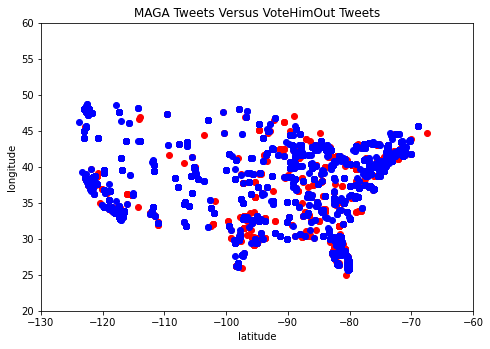

In [203]:
red_latitude = red_df['lat']
red_longitude = red_df['long']
blue_latitude = blue_df['lat']
blue_longitude = blue_df['long']
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(red_longitude, red_latitude, color='r')
ax.set_xlim([-130, -60])
ax.set_ylim([20, 60])
ax.scatter(blue_longitude, blue_latitude, color='b')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('MAGA Tweets Versus VoteHimOut Tweets')
plt.show()

TypeError: 'module' object is not callable

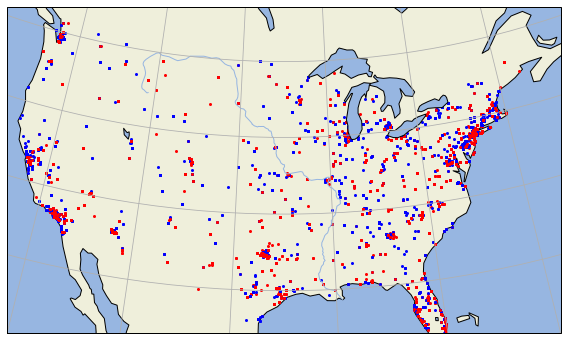

In [143]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

central_lat = 37.5
central_lon = -96
extent = [-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)
ax.gridlines()

# modify the plot by adding a scatterplot over the map
plt.scatter(
    x=for_trump_df["long"],
    y=for_trump_df["lat"],
    color="red",
    s=4,
    alpha=1,
    transform=ccrs.PlateCarree()
)

plt.scatter(
    x=against_trump_df["long"],
    y=against_trump_df["lat"],
    color="blue",
    s=4,
    alpha=1,
    transform=ccrs.PlateCarree()
)

plt.scatter(
    x=for_biden_df["long"],
    y=for_biden_df["lat"],
    color="blue",
    s=4,
    alpha=1,
    transform=ccrs.PlateCarree()
)

plt.scatter(
    x=against_biden_df["long"],
    y=against_biden_df["lat"],
    color="red",
    s=4,
    alpha=1,
    transform=ccrs.PlateCarree()
)

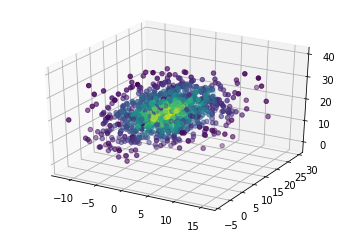

In [616]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mu=np.array([1,10,20])
sigma=np.matrix([[20,10,10],
                 [10,25,1],
                 [10,1,50]])
data=np.random.multivariate_normal(mu,sigma,1000)
values = data.T

kde = stats.gaussian_kde(values)
density = kde(values)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y, z = values
ax.scatter(x, y, z, c=density)
plt.show()

In [138]:
political_bias

,id,political bias,hashtags in tweets,lat,long,city,state_code
0,1,For Trump,"[Trump, PresidentTrump, Trump2020LandslideVict...",32.717421,-117.162771,San Diego,CA
1,2,For Trump,"[Trump, PresidentTrump, Trump2020LandslideVict...",32.717421,-117.162771,San Diego,CA
2,3,For Trump,"[BlacksForTrump, BlackVoicesForTrump, BidenIsA...",36.701463,-118.755997,Not Provided,CA
3,4,For Trump,"[realDonaldTrump, DonaldTrumpJr, Debates2020, ...",27.756767,-81.463983,Not Provided,FL
4,5,For Trump,"[Trump, TrumpTrain, TrumpPence2020]",29.758938,-95.367697,Houston,TX
...,...,...,...,...,...,...,...
46969,46970,Against Biden,"[HeelsUpHarris, CrookedJoeBiden, HunterBiden, ...",43.979280,-120.737257,Not Provided,OR
46970,46971,Against Biden,"[Biden, BidenHarris, CrookedJoeBiden]",38.894992,-77.036558,Washington,DC
46971,46972,Against Biden,"[Biden, BidenCrimeFamilly, WheresHunter, Child...",40.327013,-86.174693,Not Provided,IN
46972,46973,Against Biden,"[Trump2020NowMoreThanEver, Trump2020, DrainThe...",37.779026,-122.419906,San Francisco,CA


In [172]:
for_T = political_bias.loc[political_bias['political bias'] == "Against Biden","city"].value_counts('city', ascending=False)
for_T.head(10)
# biden_word_count = df.sort_values('count', ascending=False)[100:200]

# ax = biden_word_count.plot.bar(x='unique hashtagged words', y='count', rot=90, figsize=(20,10))
# plt.show()

Not Provided    0.541382
New York        0.126758
Los Angeles     0.037164
Las Vegas       0.019084
San Diego       0.015468
Washington      0.015066
Houston         0.012053
Phoenix         0.011249
Denver          0.009040
Buffalo         0.009040
Name: city, dtype: float64

In [38]:
name of your dataframe.to_sql("time_avg", conn, if_exists="append", index=False)
political_bias.to_sql("political_bias", conn, if_exists-="append", index=False)

SyntaxError: invalid syntax (<ipython-input-38-d5199a225035>, line 1)